# HIERARCHICAL REGRESSION | RADON CONTAMINATION DATASET

## Load libraries

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
az.style.use("arviz-darkgrid")
np.random.default_rng(8924);

## Load data

In [3]:
# Get radon data
path = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/srrs2.dat"
radon_df = pd.read_csv(path)

# Get city data
city_df = pd.read_csv(pm.get_data("cty.dat"))

In [4]:
display(radon_df.head())
print(radon_df.shape[0])

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county
0,1,AZ,AZ,4,85920,1,1,1,2,N,...,1100,112987,120287,0.3,0.0,136.060971,0,0,1,APACHE
1,2,AZ,AZ,4,85920,1,0,9,0,,...,700,70788,71188,0.6,33.3,128.784975,0,0,1,APACHE
2,3,AZ,AZ,4,85924,1,1,1,3,N,...,1145,70788,70788,0.5,0.0,150.245112,0,0,1,APACHE
3,4,AZ,AZ,4,85925,1,1,1,3,N,...,1900,52088,52288,0.6,97.2,136.060971,0,0,1,APACHE
4,5,AZ,AZ,4,85932,1,1,1,1,N,...,900,70788,70788,0.3,0.0,136.060971,0,0,1,APACHE


12777


In [5]:
display(city_df.head())
print(city_df.shape[0])

,stfips,ctfips,st,cty,lon,lat,Uppm
0,1,1,AL,AUTAUGA,-86.643,32.534,1.78331
1,1,3,AL,BALDWIN,-87.750,30.661,1.38323
2,1,5,AL,BARBOUR,-85.393,31.870,2.10105
3,1,7,AL,BIBB,-87.126,32.998,1.67313
4,1,9,AL,BLOUNT,-86.568,33.981,1.88501


3194


## Preprocess data

In [6]:
# Strip spaces from column names
radon_df.columns = radon_df.columns.map(str.strip)

# Filter to keep observations for "MN" state only
df = radon_df[radon_df.state == "MN"].copy()
city_mn_df = city_df[city_df.st == "MN"].copy()

# Compute fips
df["fips"] = 1_000 * df.stfips + df.cntyfips
city_mn_df["fips"] = 1_000 * city_mn_df.stfips + city_mn_df.ctfips

# Merge data
df = df.merge(city_mn_df[["fips", "Uppm"]], on="fips")
df = df.drop_duplicates(subset="idnum")

# Clean county names
df.county = df.county.map(str.strip)

# Compute log(radon + 0.1)
df["log_radon"] = np.log(df["activity"] + 0.1)

# Compute log of Uranium
df["log_u"] = np.log(df["Uppm"])

# Let's map floor. 0 -> Basement and 1 -> Floor
df["floor"] = df["floor"].map({0: "Basement", 1: "Floor"})

# Sort values by floor
df = df.sort_values(by="floor")

# Reset index
df = df.reset_index(drop=True)

## EDA

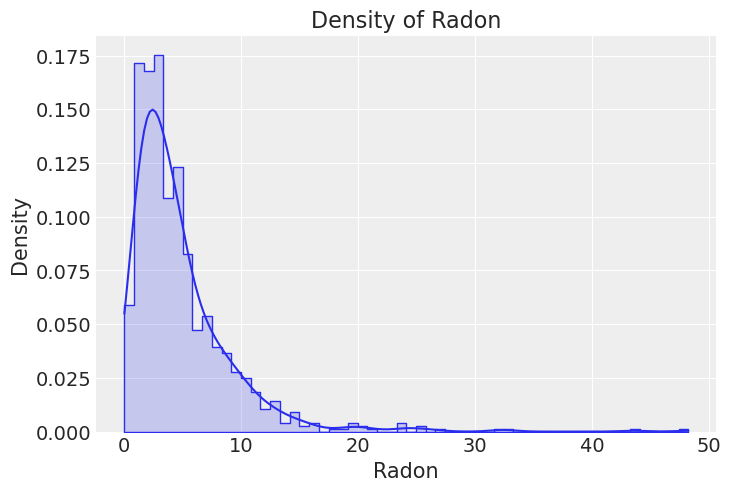

In [7]:
_, ax = plt.subplots()
sns.histplot(x="activity", alpha=0.2, stat="density", element="step", common_norm=False, data=df, ax=ax)
sns.kdeplot(x="activity", data=df, ax=ax, cut=0)
ax.set(title="Density of Radon", xlabel="Radon", ylabel="Density");

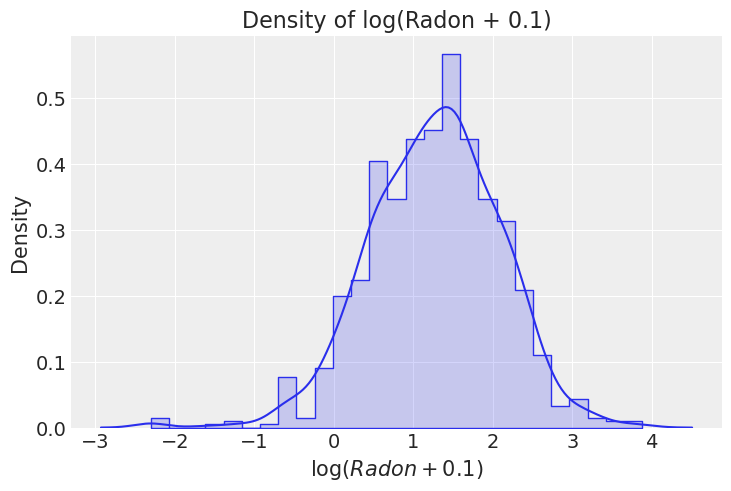

In [8]:
_, ax = plt.subplots()
sns.histplot(x="log_radon", alpha=0.2, stat="density", element="step", common_norm=False, data=df, ax=ax)
sns.kdeplot(x="log_radon", data=df, ax=ax)
ax.set(title="Density of log(Radon + 0.1)", xlabel="$\log(Radon + 0.1)$", ylabel="Density");

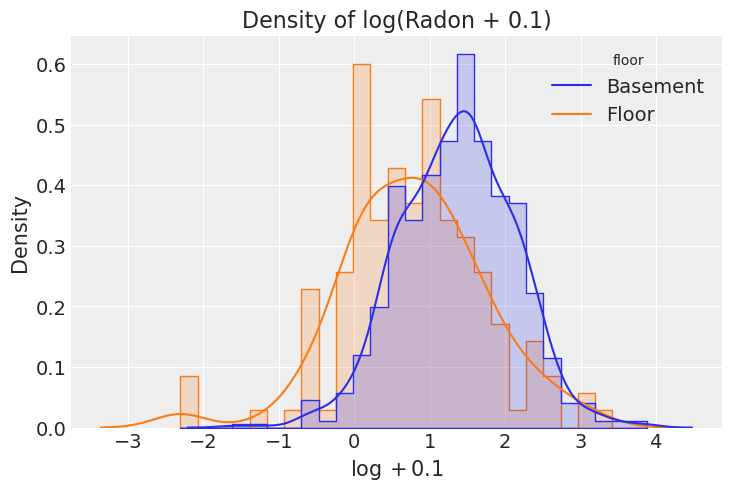

In [9]:
_, ax = plt.subplots()
sns.histplot(
    x="log_radon", hue="floor", alpha=0.2, stat="density", element="step", 
    common_norm=False, data=df, ax=ax
)
sns.kdeplot(x="log_radon", hue="floor", common_norm=False, data=df, ax=ax)
ax.set(title="Density of log(Radon + 0.1)", xlabel="$\log + 0.1$", ylabel="Density");

In [10]:
n_counties = df["county"].unique().size
print(f"Number of counties: {n_counties}")

Number of counties: 85


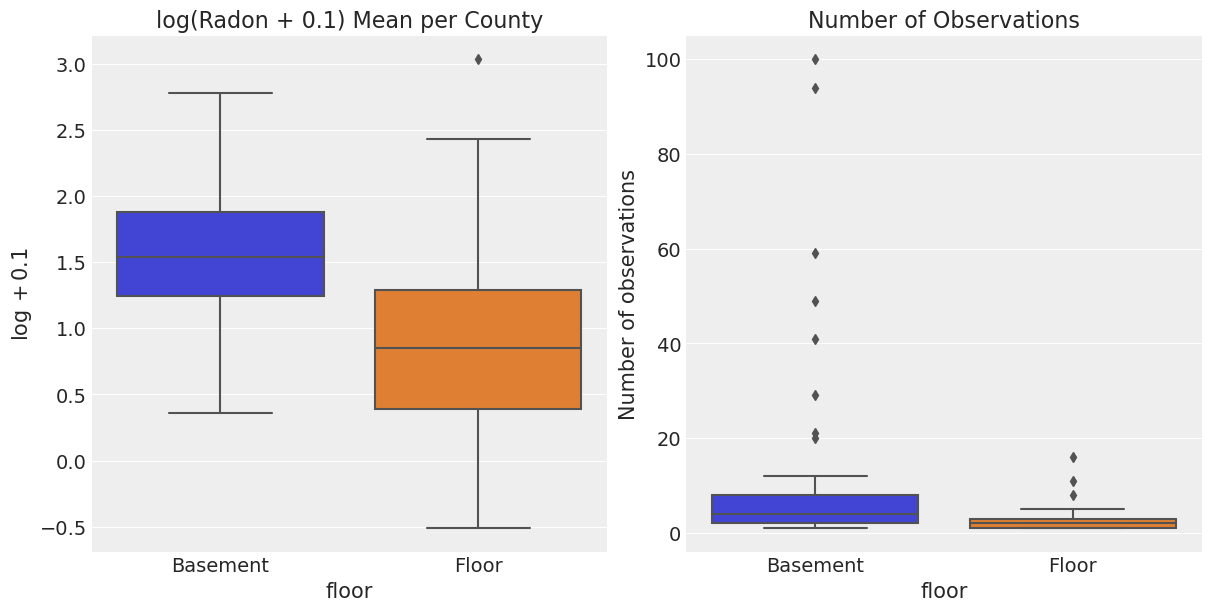

In [11]:
log_radon_county_agg  = (
    df 
    .groupby(["county", "floor"], as_index=False)
    .agg(
        log_radon_mean=("log_radon", "mean"),
        n_obs=("log_radon", "count")
    )
)

fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(12, 6), layout="constrained")
sns.boxplot(x="floor", y="log_radon_mean", data=log_radon_county_agg, ax=ax[0])
ax[0].set(title="log(Radon + 0.1) Mean per County", ylabel="$\log + 0.1$")

sns.boxplot(x="floor", y="n_obs", data=log_radon_county_agg, ax=ax[1])
ax[1].set(title="Number of Observations", xlabel="floor", ylabel="Number of observations");

In [12]:
assert df.query("county == 'YELLOW MEDICINE' and floor == 'Floor'").empty

## Complete pooling modeling

In [13]:
# Priors
pooledPriors = {
    'floor': bmb.Prior('Normal', mu = 0, sigma = 10),
    'sigma': bmb.Prior('Exponential', lam = 1)
    
}

In [14]:
# Model
pooled_model = bmb.Model(
                            'log_radon ~ 0 + floor',
                            df,
                            priors = pooledPriors
)

In [15]:
pooled_model

       Formula: log_radon ~ 0 + floor
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            floor ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [16]:
pooled_model.build()

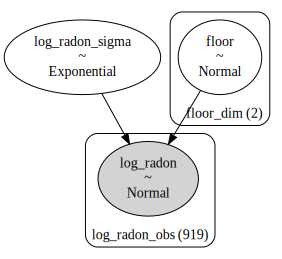

In [17]:
pooled_model.graph()

In [18]:
pooled_results = pooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, floor]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


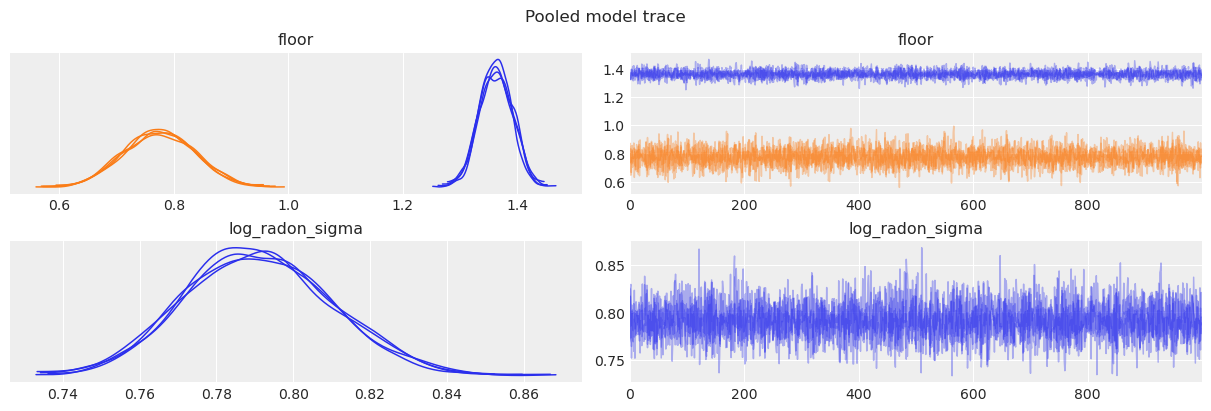

In [19]:
az.plot_trace(
                pooled_results,
                compact = True,
                chain_prop = {'ls': '-'}
)

plt.suptitle('Pooled model trace');

In [20]:
pooled_summary = az.summary(pooled_results)
pooled_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
floor[Basement],1.363,0.029,1.311,1.418,0.000,0.000,5999.0,3107.0,1.0
floor[Floor],0.775,0.062,0.662,0.892,0.001,0.001,6422.0,2935.0,1.0
log_radon_sigma,0.791,0.019,0.757,0.827,0.000,0.000,5496.0,3221.0,1.0


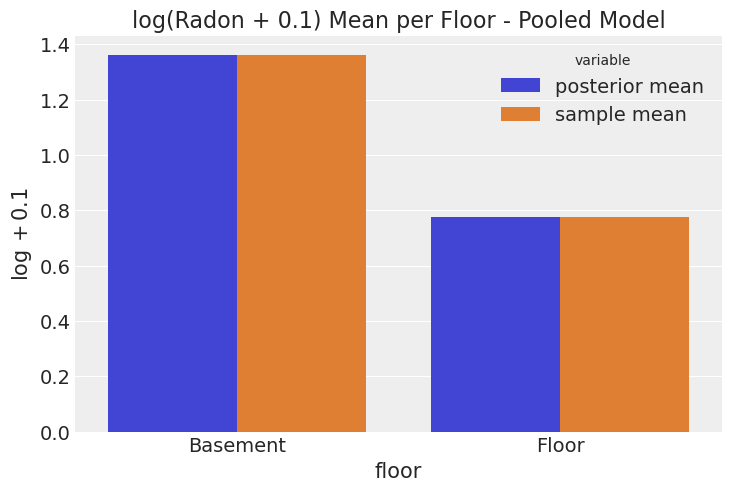

In [21]:
_, ax = plt.subplots()

(
    pooled_summary["mean"]
    .iloc[:-1]
    .reset_index()
    .assign(floor = lambda x: x["index"].str.slice(6, -1).str.strip())
    .merge(
        right=df.groupby(["floor"])["log_radon"].mean(),
        left_on="floor",
        right_index=True
    )
    .rename(columns={
        "mean": "posterior mean",
        "log_radon": "sample mean"
    })
    .melt(
        id_vars="floor",
        value_vars=["posterior mean", "sample mean"]
    )
    .pipe((sns.barplot, "data"),
        x="floor",
        y="value",
        hue="variable",
        ax=ax
    )
)
ax.set(title="log(Radon + 0.1) Mean per Floor - Pooled Model", ylabel="$\log + 0.1$");

C:\Users\bacos1\AppData\Local\Temp\ipykernel_7028\1213510270.py:9: FutureWarning: extract_dataset has been deprecated, please use extract
  pps = az.extract_dataset(pooled_results, group="posterior_predictive")["log_radon"].values


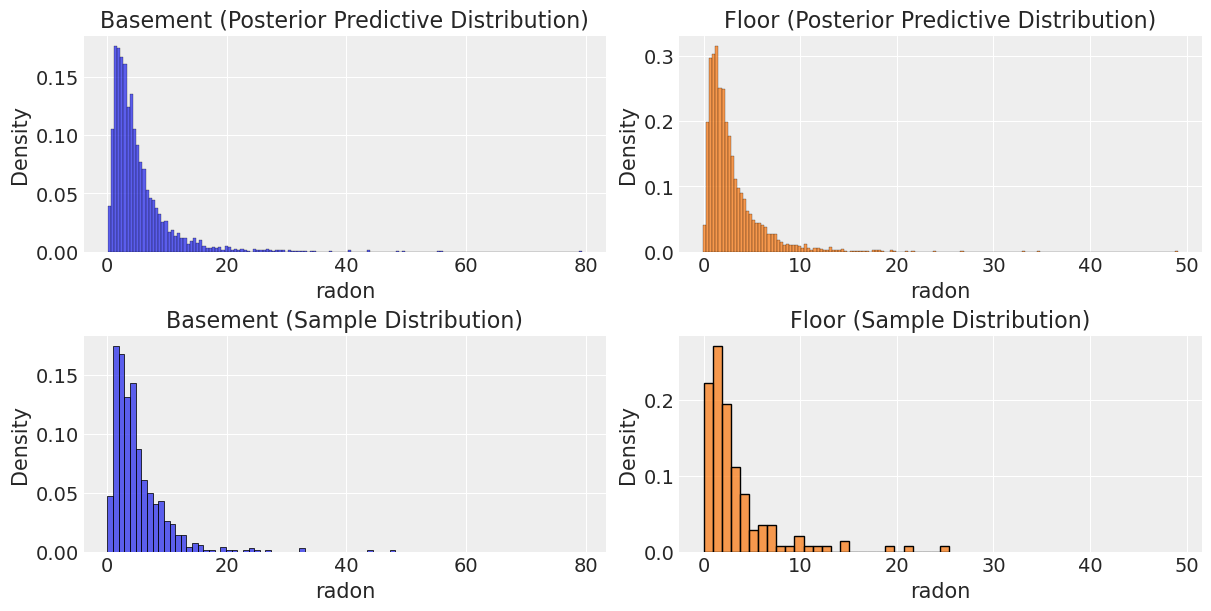

In [22]:
# Note we create a new data set. 
# One observation per group is enough to obtain posterior predictive samples for that group
# The more observations we create, the more posterior predictive samples from the same distribution
# we obtain.
new_data = pd.DataFrame({"floor": ["Basement", "Floor"]})
pooled_model.predict(pooled_results, kind="pps", data=new_data)

# Stack chains and draws and extract posterior predictive samples
pps = az.extract_dataset(pooled_results, group="posterior_predictive")["log_radon"].values

# Inverse transform the posterior predictive samples
pps = np.exp(pps) - 0.1

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), layout="constrained")
ax = ax.flatten()

sns.histplot(x=pps[0].flatten(), stat="density", color="C0", ax=ax[0])
ax[0].set(title="Basement (Posterior Predictive Distribution)", xlabel="radon", ylabel="Density")
sns.histplot(x="activity", data=df.query("floor == 'Basement'"), stat="density", ax=ax[2])
ax[2].set(title="Basement (Sample Distribution)", xlim=ax[0].get_xlim(), xlabel="radon", ylabel="Density")

sns.histplot(x=pps[1].flatten(), stat="density", color="C1", ax=ax[1])
ax[1].set(title="Floor (Posterior Predictive Distribution)", xlabel="radon", ylabel="Density")
sns.histplot(x="activity", data=df.query("floor == 'Floor'"), stat="density", color="C1", ax=ax[3])
ax[3].set(title="Floor (Sample Distribution)", xlim=ax[1].get_xlim(), xlabel="radon", ylabel="Density");

## No pooling

In [23]:
# Priors
unpooled_priors = {
    'county:floor': bmb.Prior('Normal', mu = 0, sigma = 10),
    'sigma': bmb.Prior('Exponential', lam = 1)    
}

In [24]:
unpooled_model = bmb.Model(
                            'log_radon ~ 0 + county:floor',
                            df,
                            priors = unpooled_priors
)

In [25]:
unpooled_model

       Formula: log_radon ~ 0 + county:floor
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            county:floor ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

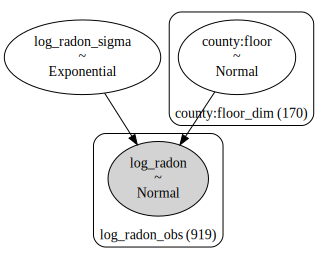

In [28]:
unpooled_model.build()
unpooled_model.graph()

In [29]:
unpooled_results = unpooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, county:floor]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.


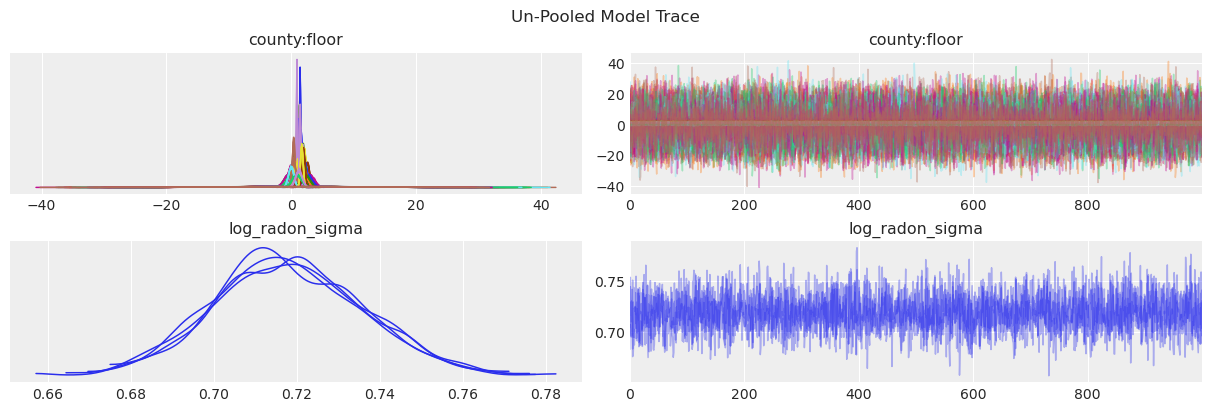

In [30]:
az.plot_trace(data=unpooled_results, compact=True, chain_prop={"ls": "-"})
plt.suptitle("Un-Pooled Model Trace");

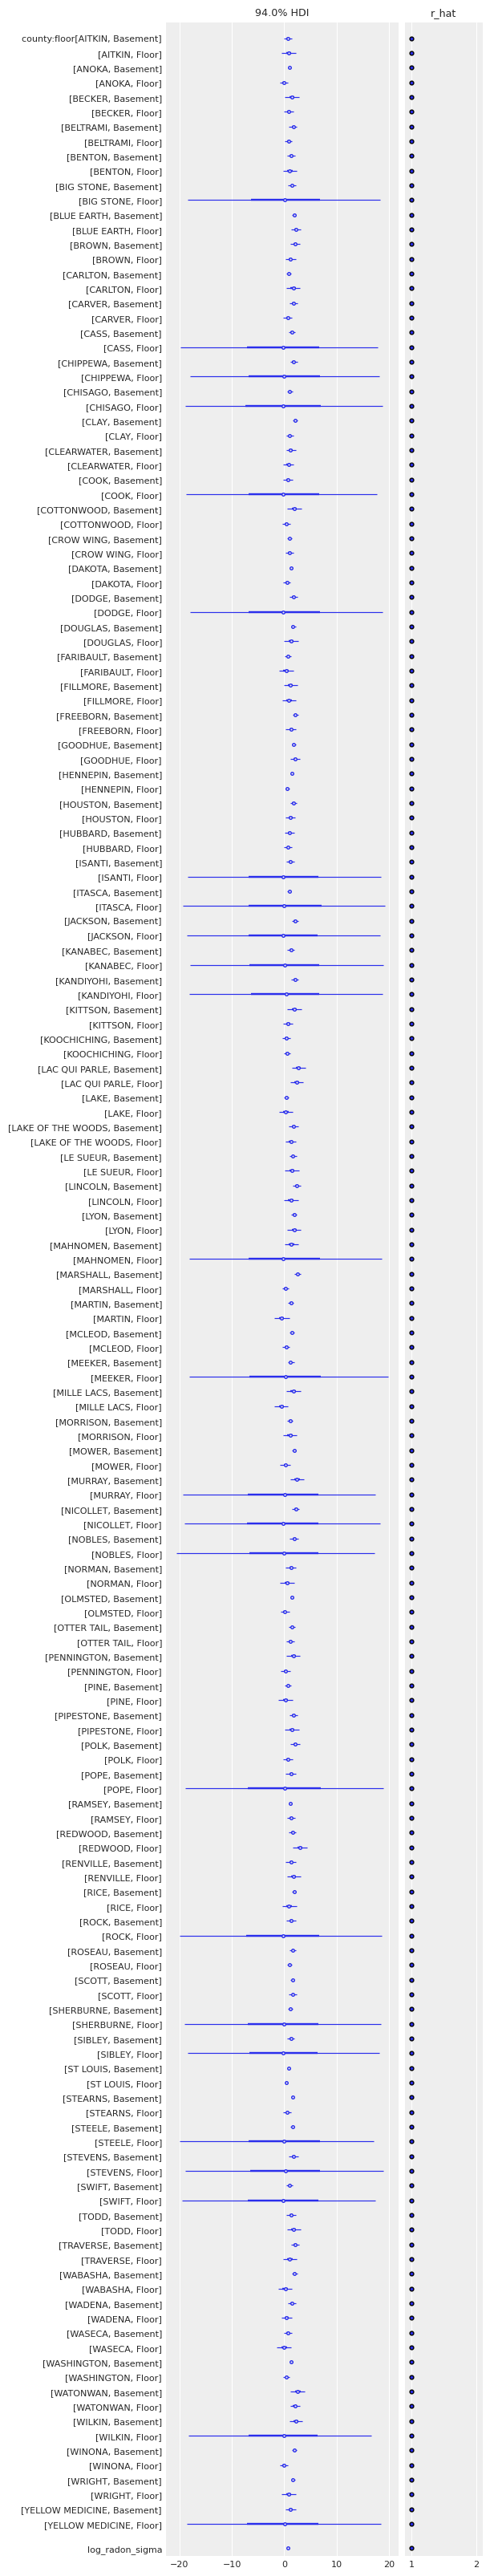

In [31]:
az.plot_forest(data=unpooled_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

In [32]:
unpooled_summary = az.summary(data=unpooled_results)

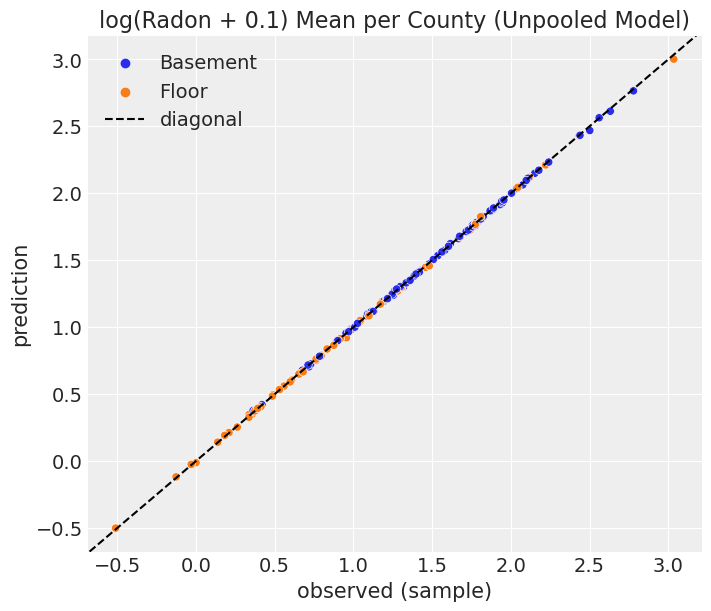

In [33]:
# Get county and floor names from summary table
var_mapping = (
    unpooled_summary
    .iloc[:-1]
    .reset_index(drop=False)["index"].str.slice(13, -1).str.split(",").apply(pd.Series)
)

var_mapping.rename(columns={0: "county", 1: "floor"}, inplace=True)
var_mapping["county"] = var_mapping["county"].str.strip()
var_mapping["floor"] = var_mapping["floor"].str.strip()
var_mapping.index = unpooled_summary.iloc[:-1].index
    
# Merge with observed values
unpooled_summary_2 = pd.concat([var_mapping, unpooled_summary.iloc[:-1]], axis=1)

fig, ax = plt.subplots(figsize=(7, 6))

(
    unpooled_summary_2
    .merge(right=log_radon_county_agg, on=["county", "floor"], how="left")
    .pipe(
        (sns.scatterplot, "data"),
        x="log_radon_mean",
        y="mean",
        hue="floor",
        ax=ax
    )
)
ax.axline(xy1=(1, 1), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set(
    title="log(Radon + 0.1) Mean per County (Unpooled Model)",
    xlabel="observed (sample)",
    ylabel="prediction",
);

## Multilevel and hierarchical models

### Partial pooling model

In [34]:
# Priors
partial_pooling_priors = {
    'Intercept': bmb.Prior('Normal', mu = 0, sigma = 10),
    '1|county': bmb.Prior('Normal', mu = 0, sigma = bmb.Prior('Exponential', lam = 1)),
    'sigma': bmb.Prior('Exponential', lam = 1)
    
}

In [35]:
# Model
partial_pooling_model = bmb.Model(
                                    formula = 'log_radon ~ 1 + (1|county)',
                                    data = df,
                                    priors = partial_pooling_priors,
                                    noncentered = False
)

In [36]:
partial_pooling_model 

       Formula: log_radon ~ 1 + (1|county)
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 10.0)
        
        Group-level effects
            1|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

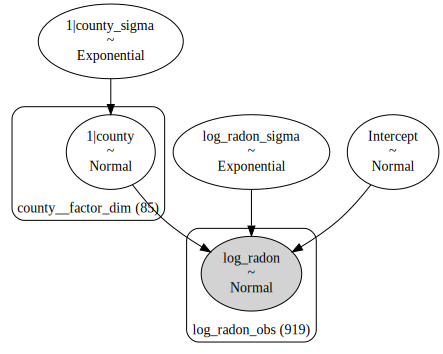

In [37]:
partial_pooling_model.build()
partial_pooling_model.graph()

In [38]:
partial_pooling_results = partial_pooling_model.fit();

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, Intercept, 1|county_sigma, 1|county]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


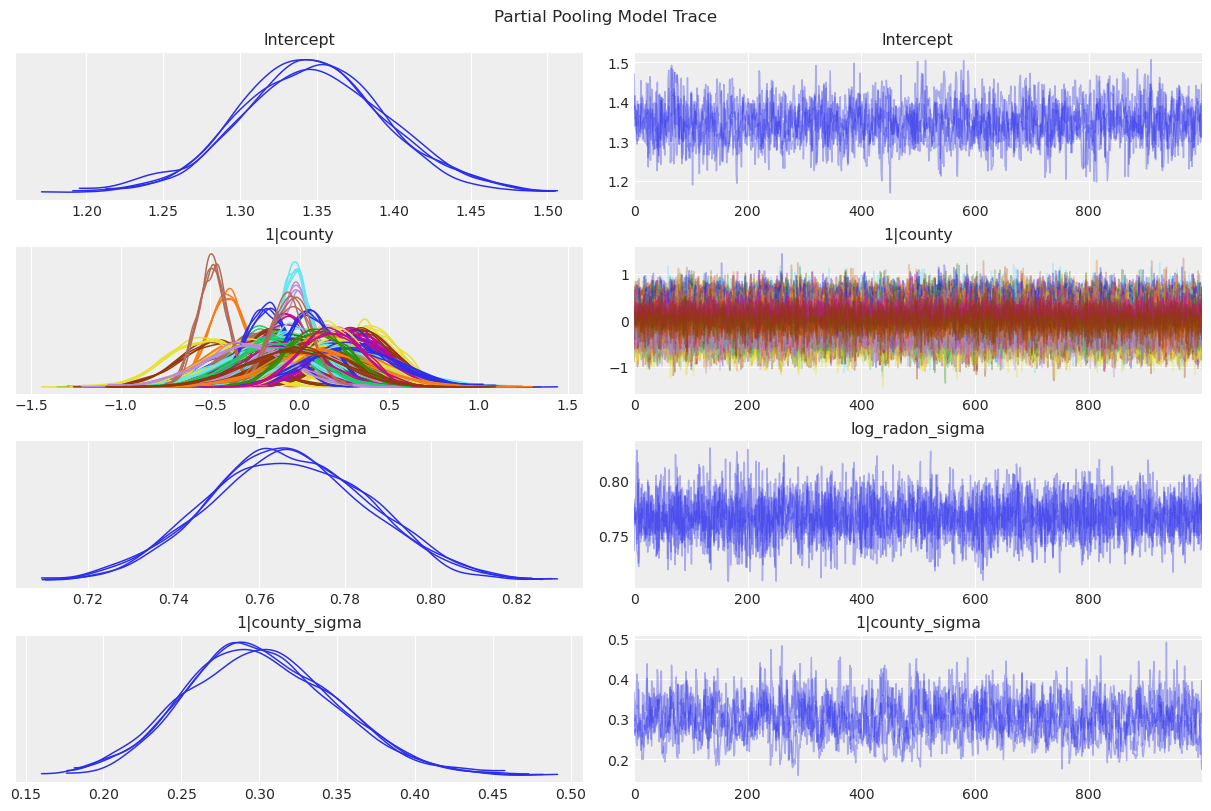

In [39]:
az.plot_trace(
        partial_pooling_results,
        compact = True,
        chain_prop={'ls': '-'}
)

plt.suptitle("Partial Pooling Model Trace");

C:\Users\bacos1\AppData\Local\Temp\ipykernel_7028\3145587883.py:4: FutureWarning: extract_dataset has been deprecated, please use extract
  pps = az.extract_dataset(partial_pooling_results, group="posterior_predictive")["log_radon"].values


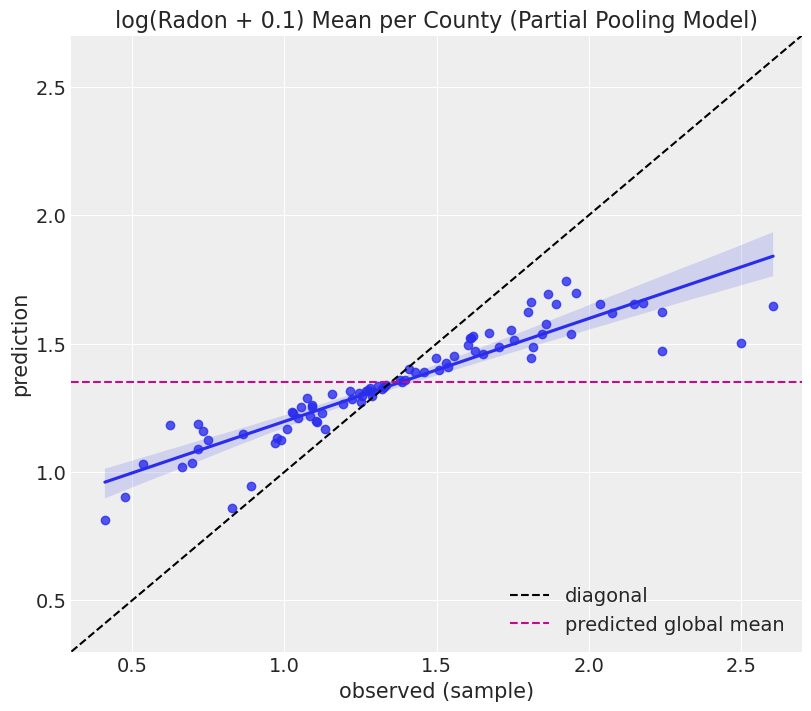

In [40]:
partial_pooling_model.predict(partial_pooling_results, kind="pps")

# Stack chains and draws. pps stands for posterior predictive samples
pps = az.extract_dataset(partial_pooling_results, group="posterior_predictive")["log_radon"].values

pps_df = pd.DataFrame(data=pps).assign(county=df["county"])
y_pred = pps_df.groupby("county").mean().mean(axis=1)
y_sample = df.groupby("county")["log_radon"].mean()

fig, ax = plt.subplots(figsize=(8, 7))
sns.regplot(x=y_sample, y=y_pred, ax=ax)
ax.axline(xy1=(1, 1), slope=1, color="black", linestyle="--", label="diagonal")
ax.axhline(y=y_pred.mean(), color="C3", linestyle="--", label="predicted global mean")
ax.legend(loc="lower right")
ax.set(
    title="log(Radon + 0.1) Mean per County (Partial Pooling Model)",
    xlabel="observed (sample)",
    ylabel="prediction",
    xlim=(0.3, 2.7),
    ylim=(0.3, 2.7),
);

### County-specific intercepts and common predictors

In [41]:
# Priors
varying_intercept_priors = {
    'floor': bmb.Prior('Normal', mu = 0, sigma = 10),
    '1|county': bmb.Prior('Normal', mu = 0, sigma = bmb.Prior('Exponential', lam = 1)),
    'sigma': bmb.Prior('Exponential', lam = 1)
}

In [42]:
varying_intercept_model = bmb.Model(
    formula="log_radon ~ 0 + floor + (1|county)",
    data=df,
    priors=varying_intercept_priors,
    noncentered=False
 )

In [43]:
varying_intercept_model

       Formula: log_radon ~ 0 + floor + (1|county)
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            floor ~ Normal(mu: 0.0, sigma: 10.0)
        
        Group-level effects
            1|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [44]:
varying_intercept_model.build()

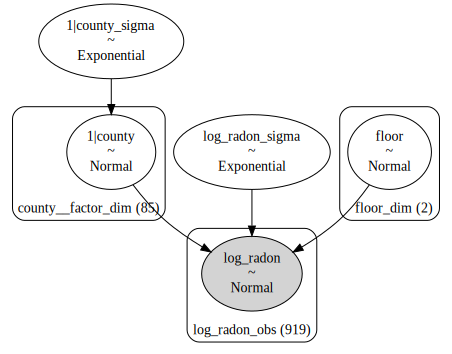

In [45]:
varying_intercept_model.graph()

In [46]:
varying_intercept_results = varying_intercept_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, floor, 1|county_sigma, 1|county]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


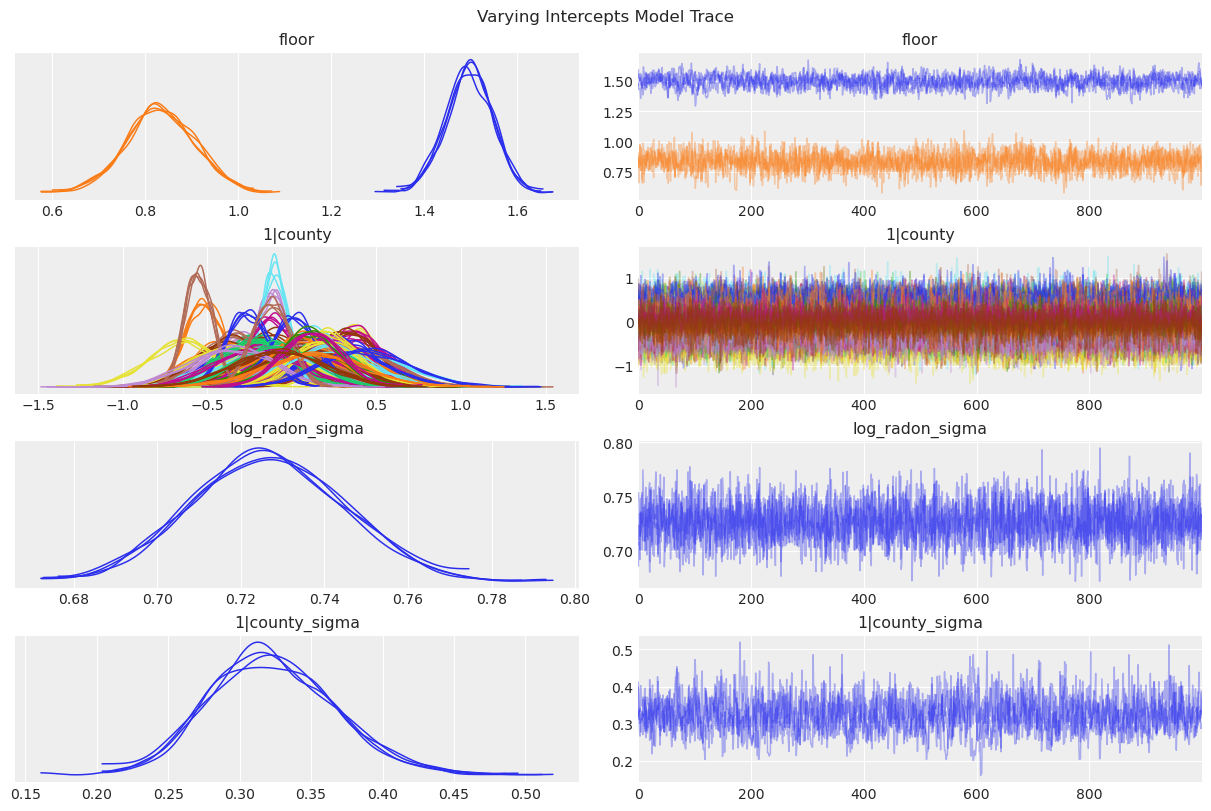

In [47]:
az.plot_trace(data=varying_intercept_results, compact=True, chain_prop={"ls": "-"});
plt.suptitle("Varying Intercepts Model Trace");

### Varying intercept and slope model

In [48]:
varying_intercept_slope_priors = {
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "floor|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("Exponential", lam=1),
}

varying_intercept_slope_model = bmb.Model(
    formula="log_radon ~ 0 + floor + (0 + floor|county)",
    data=df,
    priors=varying_intercept_slope_priors,
    noncentered=True
 )

varying_intercept_slope_model

       Formula: log_radon ~ 0 + floor + (0 + floor|county)
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            floor ~ Normal(mu: 0.0, sigma: 10.0)
        
        Group-level effects
            floor|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [49]:
varying_intercept_slope_results = varying_intercept_slope_model.fit(
    draws=2000, 
    tune=2000,
    target_accept=0.9
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, floor, floor|county_sigma, floor|county_offset]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 32 seconds.


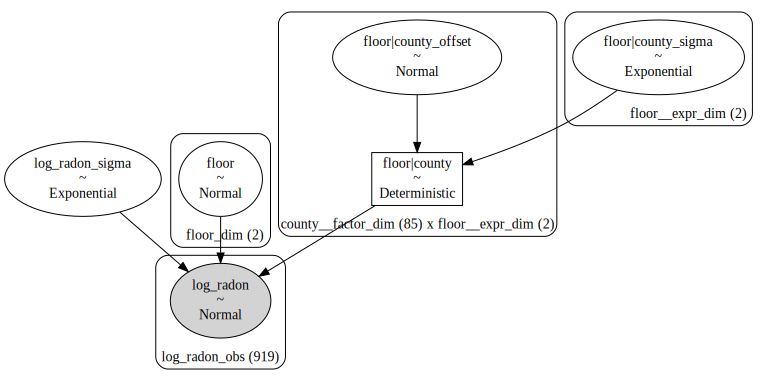

In [50]:
varying_intercept_slope_model.graph()

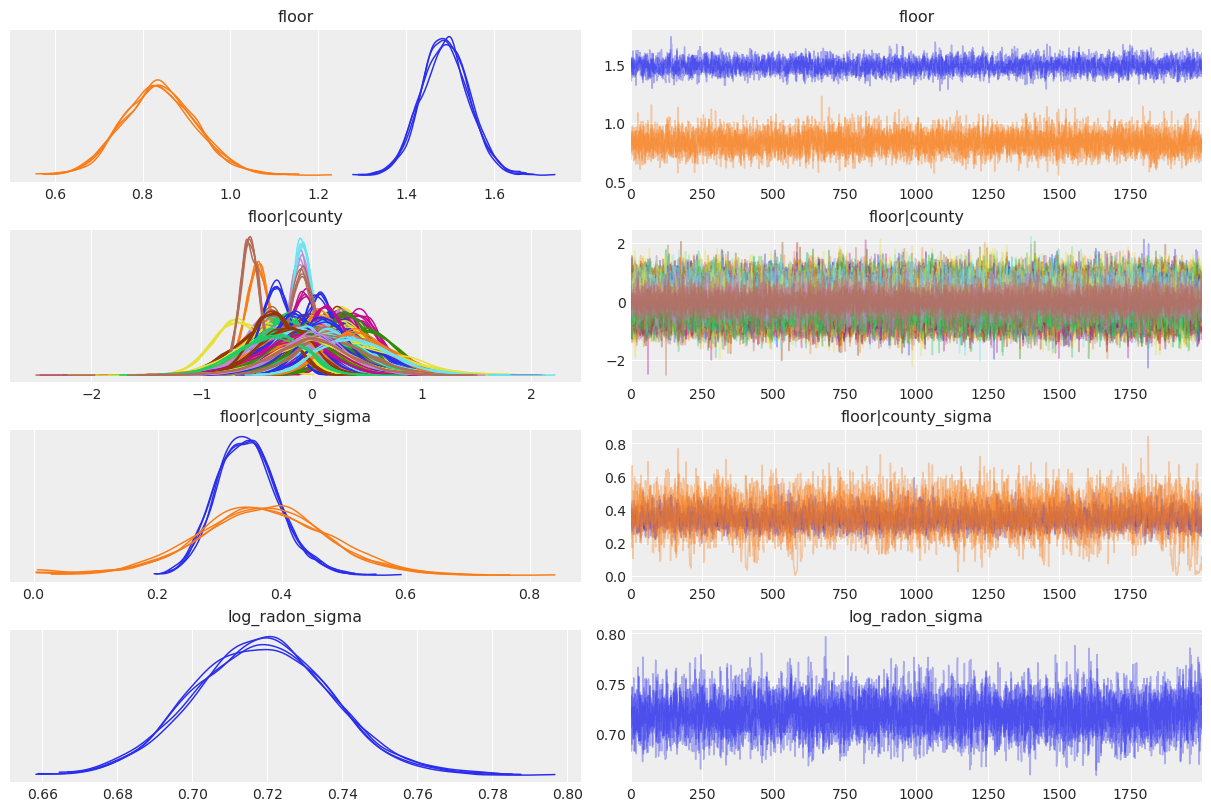

In [51]:
var_names = ["floor", "floor|county", "floor|county_sigma", "log_radon_sigma"]
az.plot_trace(
    data=varying_intercept_slope_results,
    var_names=var_names, 
    compact=True, 
    chain_prop={"ls": "-"}
);

## Adding group level perdiction

In [56]:
covariate_priors = {
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "log_u": bmb.Prior("Normal", mu=0, sigma=10),
    "floor|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("Exponential", lam=1),
}

In [57]:
covariate_model = bmb.Model(
    formula="log_radon ~ 0 + floor + log_u + (0 + floor|county)",
    data=df,
    priors=covariate_priors,
    noncentered=True
 )

In [58]:
covariate_model

       Formula: log_radon ~ 0 + floor + log_u + (0 + floor|county)
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            floor ~ Normal(mu: 0.0, sigma: 10.0)
            log_u ~ Normal(mu: 0.0, sigma: 10.0)
        
        Group-level effects
            floor|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

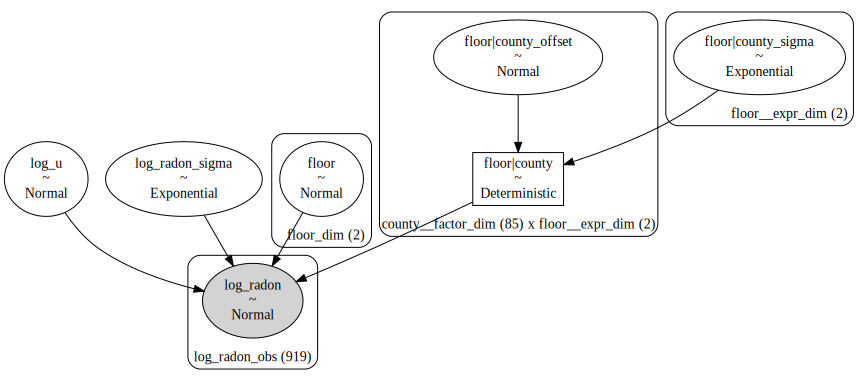

In [59]:
covariate_model.build()
covariate_model.graph()

In [63]:
covariate_results = covariate_model.fit(draws = 2000, tune = 2000, target_accept = 0.9, chains = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [log_radon_sigma, floor, log_u, floor|county_sigma, floor|county_offset]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


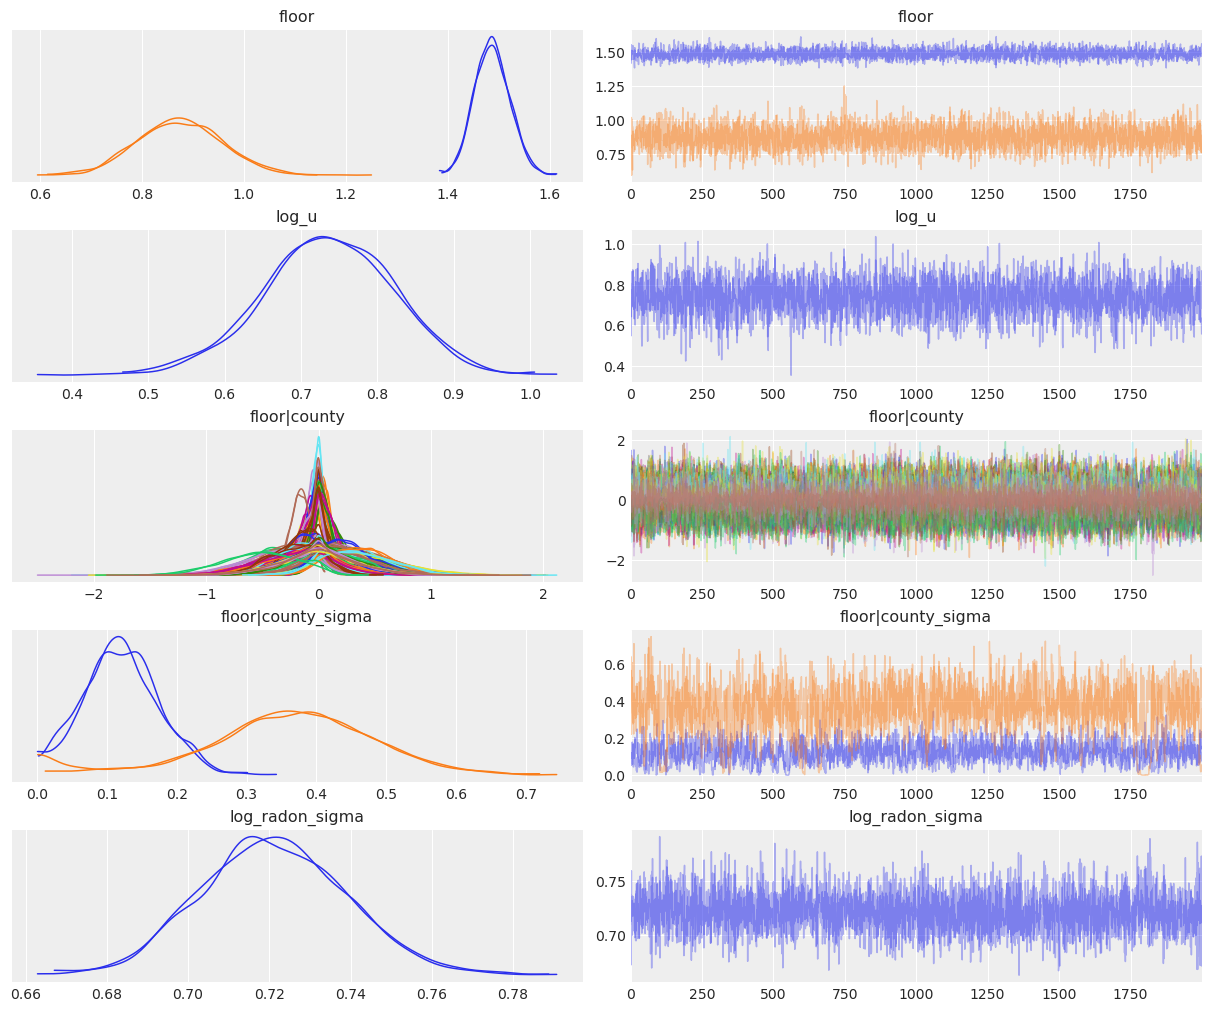

In [64]:
var_names = ["floor", "log_u", "floor|county", "floor|county_sigma", "log_radon_sigma"]
az.plot_trace(
    data=covariate_results,
    var_names=var_names, 
    compact=True, 
    chain_prop={"ls": "-"}
);

In [66]:
# get log_u values per county
log_u_sample = df.groupby(["county"])["log_u"].mean().values

# compute the slope posterior samples
log_u_slope = covariate_results.posterior["log_u"].values[..., None] * log_u_sample

# Compute the posterior for the floor coefficient when it is Basement
intercepts = (
    covariate_results.posterior.sel(floor_dim="Basement")["floor"]
    + covariate_results.posterior.sel(floor__expr_dim="Basement")["floor|county"] 
).values

y_predicted = (intercepts + log_u_slope).reshape(4000, n_counties).T

# reduce the intercepts posterior samples to the mean per county
mean_intercept = intercepts.mean(axis=2)[..., None] + log_u_slope

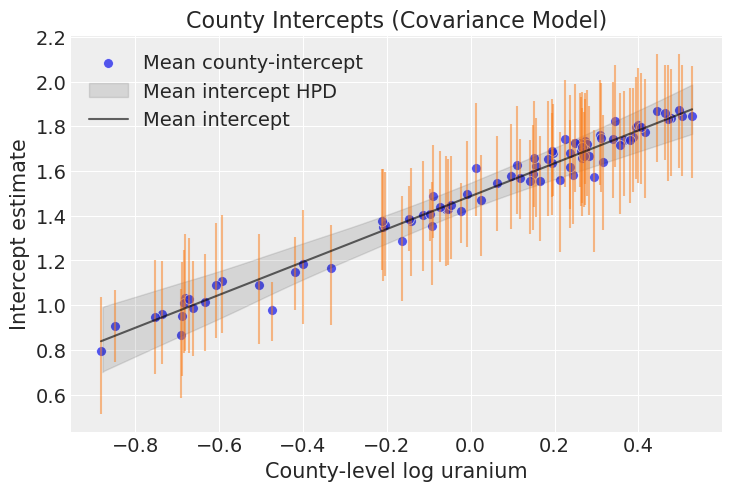

In [67]:
fig, ax = plt.subplots()

y_predicted_bounds = np.quantile(y_predicted, q=[0.03, 0.96], axis=1)

sns.scatterplot(
    x=log_u_sample,
    y=y_predicted.mean(axis=1),
    alpha=0.8,
    color="C0",
    s=50,
    label="Mean county-intercept",
    ax=ax
)
ax.vlines(log_u_sample, y_predicted_bounds[0], y_predicted_bounds[1], color="C1", alpha=0.5)

az.plot_hdi(
    x=log_u_sample,
    y=mean_intercept,
    color="black",
    fill_kwargs={"alpha": 0.1, "label": "Mean intercept HPD"},
    ax=ax
)

sns.lineplot(
    x=log_u_sample,
    y=mean_intercept.reshape(4000, n_counties).mean(axis=0),
    color="black",
    alpha=0.6,
    label="Mean intercept",
    ax=ax
)

ax.legend(loc="upper left")
ax.set(
    title="County Intercepts (Covariance Model)",
    xlabel="County-level log uranium",
    ylabel="Intercept estimate"
);

## Summary

In [68]:
# generate posterior predictive samples
pooled_model.predict(pooled_results, kind="pps")
unpooled_model.predict(unpooled_results, kind="pps")
partial_pooling_model.predict(partial_pooling_results, kind="pps")

# stack chain and draw values
pooled_pps = az.extract_dataset(pooled_results, group="posterior_predictive")["log_radon"].values
unpooled_pps = az.extract_dataset(unpooled_results, group="posterior_predictive")["log_radon"].values
partial_pooling_pps = az.extract_dataset(partial_pooling_results, group="posterior_predictive")["log_radon"].values

# Generate predictions per county
pooled_pps_df = pd.DataFrame(data=pooled_pps).assign(county=df["county"])
y_pred_pooled = pooled_pps_df.groupby("county").mean().mean(axis=1)

unpooled_pps_df = pd.DataFrame(data=unpooled_pps).assign(county=df["county"])
y_pred_unpooled = unpooled_pps_df.groupby("county").mean().mean(axis=1)

partial_pooling_pps_df = pd.DataFrame(data=partial_pooling_pps).assign(county=df["county"])
y_pred_partial_pooling = partial_pooling_pps_df.groupby("county").mean().mean(axis=1)

# observed values
y_sample = df.groupby("county")["log_radon"].mean()

C:\Users\bacos1\AppData\Local\Temp\ipykernel_7028\54649629.py:7: FutureWarning: extract_dataset has been deprecated, please use extract
  pooled_pps = az.extract_dataset(pooled_results, group="posterior_predictive")["log_radon"].values
C:\Users\bacos1\AppData\Local\Temp\ipykernel_7028\54649629.py:8: FutureWarning: extract_dataset has been deprecated, please use extract
  unpooled_pps = az.extract_dataset(unpooled_results, group="posterior_predictive")["log_radon"].values
C:\Users\bacos1\AppData\Local\Temp\ipykernel_7028\54649629.py:9: FutureWarning: extract_dataset has been deprecated, please use extract
  partial_pooling_pps = az.extract_dataset(partial_pooling_results, group="posterior_predictive")["log_radon"].values


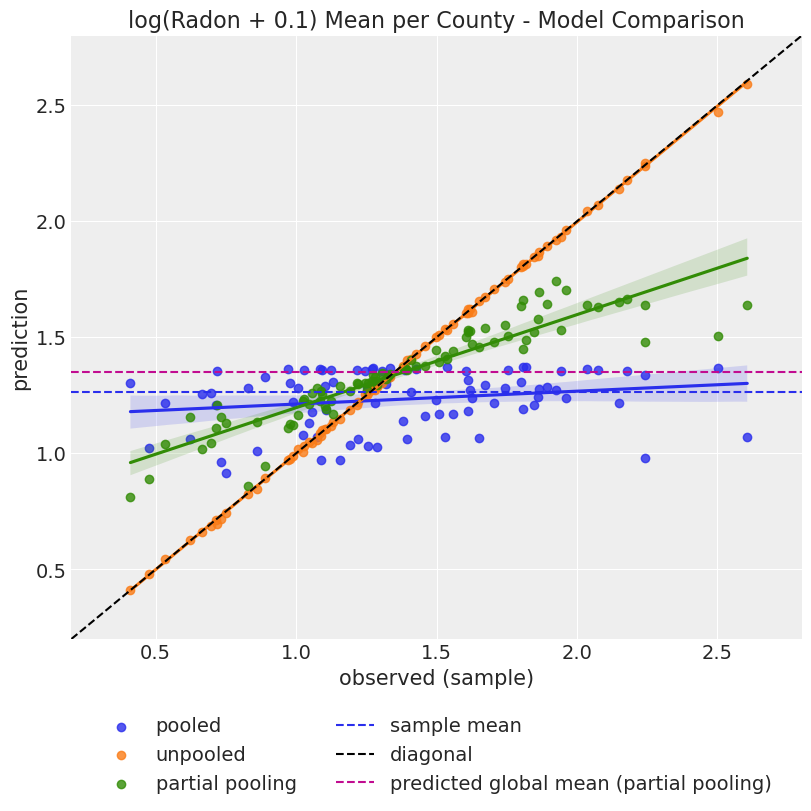

In [69]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.regplot(x=y_sample, y=y_pred_pooled, label="pooled", color="C0", ax=ax)
sns.regplot(x=y_sample, y=y_pred_unpooled, label="unpooled", color="C1", ax=ax)
sns.regplot(x=y_sample, y=y_pred_partial_pooling, label="partial pooling", color="C2", ax=ax)
ax.axhline(y=df["log_radon"].mean(), color="C0", linestyle="--", label="sample mean")
ax.axline(xy1=(1, 1), slope=1, color="black", linestyle="--", label="diagonal")
ax.axhline(
    y=y_pred_partial_pooling.mean(), color="C3",
    linestyle="--", label="predicted global mean (partial pooling)"
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
ax.set(
    title="log(Radon + 0.1) Mean per County - Model Comparison",
    xlabel="observed (sample)",
    ylabel="prediction",
    xlim=(0.2, 2.8),
    ylim=(0.2, 2.8),
);